In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
pip install nltk

In [4]:
import nltk

In [5]:
nltk.download("punkt") # ihtiyacımız olan tokenizeler punkt'un içinde

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
from nltk.tokenize import sent_tokenize
#cümleleri ayırmak için tokenize kullanılır

In [7]:
from nltk.tokenize import word_tokenize

In [8]:
from nltk.tokenize import TreebankWordTokenizer

In [9]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
from nltk.corpus import stopwords

# Türkçe stopword listesini yükle
turkish_stopwords = stopwords.words('turkish')

In [11]:
#stemma=ekleri kaldırma
#lema=kökleri bulur
#geldim - gelmek

In [12]:
pip install TurkishStemmer

In [13]:
from TurkishStemmer import TurkishStemmer

In [14]:
df=pd.read_csv("textfiltre - Sayfa2.csv")

In [15]:
df.head()

,text,etiket
0,Yarın da çalışıyorum pazarteside çalışıyorum c...,intihara meyilli
1,Artik umurumda olmaz kim bana ne demis ne deme...,intihara meyilli
2,Canımı yakan bir kaç detay var ve ben halledem...,intihara meyilli
3,yazık bize ya gencecik yaşımızda hasta ettiler...,intihara meyilli
4,Sen hiç ‘hiç’ oldun mu?,intihara meyilli


In [16]:
pip install ydata_profiling

In [17]:
import ydata_profiling
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Dataset Visualization


In [18]:
import matplotlib.pyplot as plt

In [19]:
labels = ['nötr','intihara meyilli','şiddet eğilimli','tehdit altında']

<Axes: ylabel='count'>

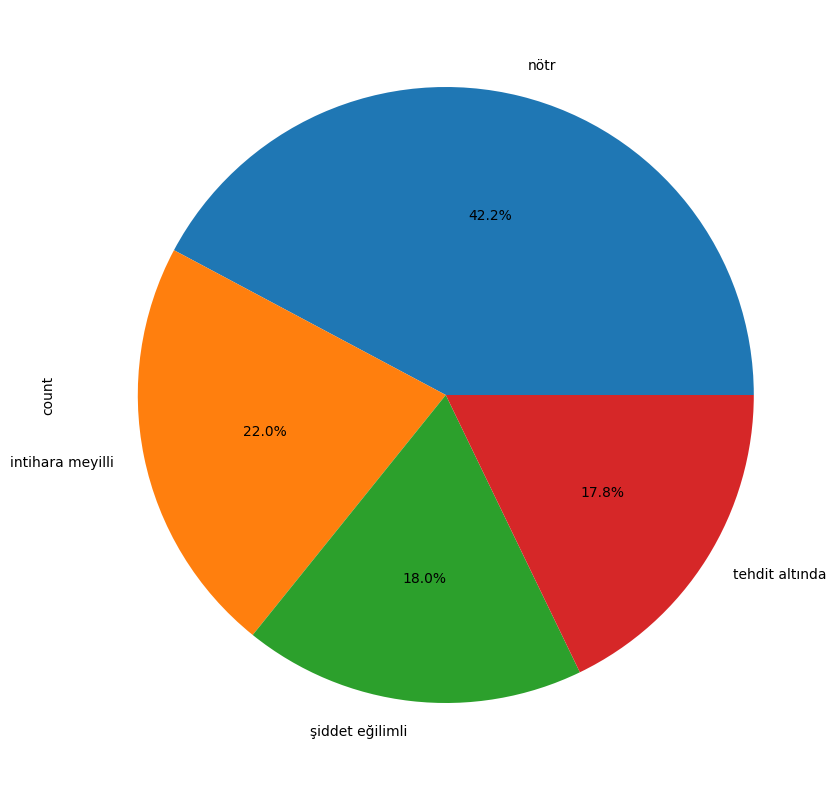

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
df['etiket'].value_counts().plot.pie(autopct = '%1.1f%%', labels=labels)

## PreProcessing

In [21]:
!pip install simpletransformers

In [22]:
from simpletransformers.classification import ClassificationModel

In [23]:
import re
import string
import pickle
from collections import defaultdict

PATH_ROOT = r'../'
PATH_STOPWORDS_TR = PATH_ROOT + 'data/stopwords_tr_interpress.pkl'
PATH_BLACKLIST_TR = PATH_ROOT + 'data/tr-blacklist.pkl'

In [24]:
#  load stopwords
def get_stopwords():
    try:
        with open(PATH_STOPWORDS_TR, 'rb') as data_file:
            return pickle.load(data_file)
    except IOError as exc:
        raise IOError("No such stopwords file! Error: " + str(exc))

#  load blacklist
def get_blacklist():
    try:
        with open(PATH_BLACKLIST_TR, 'rb') as data_file:
            return pickle.load(data_file)
    except IOError as exc:
        raise IOError("No such stopwords file! Error: " + str(exc))


#  cleaning stopwords
def clean_stopwords(text):
    # text: str
    text = text.split(" ")
    filtered_list = []
    stopwords = get_stopwords()
    for word in text:
        if word not in stopwords:
            filtered_list.append(word)

    text = ' '.join(filtered_list)
    return text

#  cleaning blacklist
def clean_blacklist(text):
    # text: str
    # return: str
    text = text.split(" ")
    filtered_list = []
    blacklist = get_blacklist()
    for word in text:
        if word not in blacklist:
            filtered_list.append(word)

    text = ' '.join(filtered_list)
    return text

#  cleaning URLs
def clean_url(text):
    #  text: str
    #  return: str
    reg_url = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
    pattern_url = re.compile(reg_url)
    text = pattern_url.sub('',text)
    return text

#  cleaning paylasim
def clean_paylasim(text):
    reg_paylasim='\S*@\S*\s?'
    pattern_paylasim = re.compile(reg_paylasim)
    text = pattern_paylasim.sub('',text)
    return text

#  cleaning punctuation
def clean_punctuation(text):
    #regex = re.compile('[%s]' % re.escape(string.punctuation))
    #text = regex.sub(" ", text)
    text = text.translate(text.maketrans("", "", string.punctuation))
    return text

#  cleaning digits
def clean_numbers(text):
    remove_digits = str.maketrans('', '', string.digits)
    text = text.translate(remove_digits)
    return text

def listToString(text):
    #  text: string
    #  return: string
    str1 = " "
    return (str1.join(text))

#  cleaning postfix
#  for example: Venezuela'nın ==> Venezuela
def clean_postfix(text):
    #  text: list
    #  return: str
    spesific_punctation = [39, 8217] # ascii codes of spesific punctations
    all_words = defaultdict(list)
    counter = 0
    for i, word in enumerate(text):
        if len(word) > 2:
            if chr(8217) in word:
                replaced_word = word.replace(chr(8217), " ")  #  clean for ’
                replaced_word = replaced_word.split(" ")[0]
                all_words[i].append(replaced_word)
            elif chr(39) in word:
                replaced_word = word.replace(chr(39), " ")  # clean for '
                replaced_word = replaced_word.split(" ")[0]
                all_words[i].append(replaced_word)
            else:
                all_words[i].append(word)
    all_words = sorted(all_words.items())

    text = ""
    for i in range(len(all_words)):
        text = text + " " + all_words[i][1][0]

    return text

def clean_text(text):
    #  text: string
    #  return: string
    text = text.lower()
    cleaned_paylasim = clean_paylasim(text)
    cleaned_paylasim_url = clean_url(cleaned_paylasim)
    cleaned_paylasim_url = listToString(cleaned_paylasim_url.split("."))
    cleaned_paylasim_url = cleaned_paylasim_url.split(" ")
    cleaned_paylasim_url_postfix = clean_postfix(cleaned_paylasim_url)
    cleaned_paylasim_url_postfix_punctuation = clean_punctuation(cleaned_paylasim_url_postfix)
    cleaned_paylasim_url_postfix_punctuation_numbers = clean_numbers(cleaned_paylasim_url_postfix_punctuation)
    cleaned_paylasim_url_postfix_punctuation_numbers_stopwords = clean_stopwords(cleaned_paylasim_url_postfix_punctuation_numbers)
    cleaned_paylasim_url_postfix_punctuation_numbers_stopwords_blacklist = clean_blacklist(cleaned_paylasim_url_postfix_punctuation_numbers_stopwords)

    filtered_sentence = []
    for word in cleaned_paylasim_url_postfix_punctuation_numbers_stopwords_blacklist.split(" "):
        if len(word) > 2:
            filtered_sentence.append(word)

    text = ' '.join(filtered_sentence)
    return text


In [25]:
df['text']=df['text'].str.lower() #büyük harfle yazılmış 10000 yorum küçük harfe çevirdi
df['text']=df['text'].str.replace('[^\W\S]','')#noktalama işaretlerini kaldırır
df['text']=df['text'].str.replace('\d+','')#rakamları kaldırır
df['text']=df['text'].str.replace('\n','')#yeni satırları kaldırır
df['text']=df['text'].str.replace('\r','')#enteri kaldırır
df['text'] = df['text'].astype(str).apply(lambda x: re.sub(r'@\w+', '', x))

In [26]:
df.sample(5)

,text,etiket
1408,"eşim sürekli beni ayrılıkla tehdit ediyor, bu ...",tehdit altında
2412,ayet fir olanlar diyor ona rab inden bir muciz...,nötr
1578,diyet yaparken düzenli olarak tartılmak dost m...,nötr
2121,kadınlara hayvanlara doğaya yaptığınız eziyet ...,nötr
1820,sahip olmak istedigi elbise giyip feminen maky...,nötr


In [27]:
df["labels"]=pd.factorize(df.etiket)[0]

In [28]:
df.sample(6)

,text,etiket,labels
1680,kadın susmayacak,nötr,3
1462,arkadaşın aracında an itibari diyarbakir sıcak...,nötr,3
532,"okumaktan, bu iğrenç düzeninizden, kaçmak zoru...",intihara meyilli,0
1080,sevdiğin kişi başkasıyla evlendiyse onların yu...,şiddet eğilimli,1
62,yaklaşık üç saat önce yatıyorum yatayım da bit...,intihara meyilli,0
2363,salak kalbim kadar incittiler seni umarım akla...,nötr,3


In [29]:
print(df.columns)

Index(['text', 'etiket', 'labels'], dtype='object')


In [30]:
print(df.index)

RangeIndex(start=0, stop=2490, step=1)


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2490 entries, 0 to 2489
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2490 non-null   object
 1   etiket  2490 non-null   object
 2   labels  2490 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 58.5+ KB


In [32]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df,test_size=0.2,random_state=42)

In [33]:
train=train[["text","labels"]]
test=test[["text","labels"]]

In [34]:
train

,text,labels
290,i̇şte gidiyorum mutlu olun!! ...,0
1503,okul bitti ilk iş teklifini aldım,3
1518,gece bekçileri sözde geziyorlarda geceleri yük...,3
599,niye öldürdün lan hayvanı kaltak karı boydan b...,1
416,ölüm ne kadar güzel bir sey dimi dostlarim,0
...,...,...
1638,makyaj yapmadan dışarıya çıkan kız yok abi yok,3
1095,"sen şiddeti hak ediyorsun, iyi olmuş",1
1130,ilgiden öldürürüm mesela,1
1294,"dana önce konuştuğum, elinde uygunsuz fotoğraf...",2


In [35]:
X = train['text'].apply(lambda r: str(r))
y = train['labels'].astype(int)

In [36]:
# Veriyi eğitim ve test kümelerine ayırıyoruz
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [38]:
pip install snowballstemmer

In [39]:
from snowballstemmer import TurkishStemmer

def turkish_tokenizer(text):
    stemmer = TurkishStemmer()
    tokens = text.split()
    stems = [stemmer.stem(token) for token in tokens]
    return stems

vect = CountVectorizer(stop_words='turkish', ngram_range=(1, 2), tokenizer=turkish_tokenizer)

In [40]:
model=ClassificationModel("bert","dbmdz/bert-base-turkish-128k-cased",num_labels=4,use_cuda=True,args={"reprocess_input_data":True,
                                                                                                     "overwrite_output_dir":True,
                "num_train_epochs":4,"train_batch_size":64,"fp16":False,"output_dir":"bert_model"})

config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

In [41]:
model.train_model(train)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/32 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/32 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/32 [00:00<?, ?it/s]

Running Epoch 4 of 4:   0%|          | 0/32 [00:00<?, ?it/s]

(128, 0.42487880229600705)

In [42]:
result,model_outputs,wrong_predictions=model.eval_model(test)

0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

In [43]:
predictions=model_outputs.argmax(axis=1)

In [44]:
actuals=test.labels.values

In [45]:
from sklearn.metrics import accuracy_score
accuracy_score(actuals,predictions)

0.8975903614457831

In [46]:
result,model_outputs,wrong_predictions=model.eval_model(test)

0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

In [47]:
print(result)

{'mcc': 0.8560163033327024, 'eval_loss': 0.3231783628463745}


In [48]:
import pickle

In [49]:
from transformers import BertForSequenceClassification, BertTokenizer

In [50]:
data = {
    "model": model,
    "tokenizer": vect
}

with open('saved_bert_model.pkl', 'wb') as file:
    pickle.dump(data, file)

In [51]:
import pickle
from transformers import BertForSequenceClassification, BertTokenizer

with open('saved_bert_model.pkl', 'rb') as file:
    data = pickle.load(file)

model = data["model"]
tokenizer = data["tokenizer"]

# Now you can use the loaded model and tokenizer for your BERT-based tasks

In [52]:
y_pred = model.predict(train['text'].tolist())
y_pred

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

(array([0, 3, 3, ..., 1, 2, 2]),
 array([[ 4.17042971, -0.66398895, -0.94884449, -1.49592948],
        [-0.77577597, -1.88569582, -1.96648502,  3.55123425],
        [-2.26887941, -2.26509809, -1.48230112,  4.02207851],
        ...,
        [-1.13542473,  3.96909094, -0.06479359, -1.85873592],
        [-1.00257373, -0.88628441,  4.803792  , -1.15332723],
        [-0.84823185,  0.27300429,  3.97217441, -1.74854267]]))

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [54]:
y_pred = model.predict(X_test)
y_true = y_test

print(y_true.shape)
print(y_pred.shape)

KeyError: 0

In [ ]:
print(df.columns)

In [ ]:
print(df.index)

In [ ]:
# Sınıf dağılımını ve etiketlerini kontrol edin
print(f"y_true sınıf sayısı: {np.unique(y_true).size}")
print(f"y_pred sınıf sayısı: {np.unique(y_pred).size}")

# Performans metriklerini hesaplama
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
confusion_mat = confusion_matrix(y_true, y_pred)

print(f'Doğruluk: {accuracy:.2f}')
print(f'Kesinlik: {precision:.2f}')
print(f'Duyarlılık: {recall:.2f}')
print(f'F1-Skor: {f1:.2f}')

In [55]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
